<a href="https://colab.research.google.com/github/Tien84/Face-Detection/blob/master/GridSearch_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas

In [2]:
!pip install numpy

In [3]:
!pip install matplotlib

In [4]:
!pip install sklearn

In [5]:
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

data = pd.read_csv('/content/driver/My Drive/LSTM_Model/AAPL.csv', header=0, index_col=0)
#data= data[::-1] 
data.index.freg='Date'
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,58.500000,58.928570,58.428570,58.747143,56.011238,75564699
2012-01-04,58.599998,59.240002,58.468571,59.062859,56.312252,65061108
2012-01-05,59.278572,59.792858,58.952858,59.718571,56.937424,67816805
2012-01-06,59.967140,60.392857,59.888573,60.342857,57.532646,79596412
2012-01-09,60.788570,61.107143,60.192856,60.247143,57.441391,98505792
...,...,...,...,...,...,...
2020-01-03,297.149994,300.579987,296.500000,297.429993,293.598297,36633878
2020-01-06,293.790009,299.959991,292.750000,299.799988,295.937744,29644644
2020-01-07,299.839996,300.899994,297.480011,298.390015,294.545959,26207813


In [7]:
# summarize shape
print(data.shape)

(2018, 6)


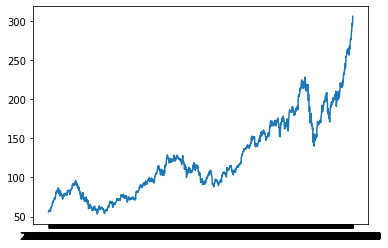

In [8]:
from matplotlib import pyplot
# plot
pyplot.plot(data['Adj Close'])
pyplot.show()

In [9]:
open_price = data.iloc[:,1:2]
train_set = open_price[:1345].values
test_set = open_price[1345:].values
print("Train size: ",train_set.shape)
print("Test size:",test_set.shape)

Train size:  (1345, 1)
Test size: (673, 1)


In [10]:
# grid search lstm
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [11]:
from sklearn.model_selection import train_test_split
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [12]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

In [13]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [14]:
# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

In [22]:
# fit a model
def model_fit (train, config):
  return None

In [23]:
# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# reshape input data into [samples, timesteps, features]
	n_features = 1
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
	model = Sequential()
	model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

In [24]:
def model_predict (model, history, offset):
  return history[-offset]

In [16]:
 # forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# reshape sample into [samples, timesteps, features]
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

In [17]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

In [47]:
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	#key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	#result = mean(scores)
	#print('> Model[%s] %.3f' % (key, result))
	#return (key, result)
	return scores

In [42]:
# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [43]:
# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [12]
	n_nodes = [100]
	n_epochs = [50]
	n_batch = [1, 150]
	n_diff = [12]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

In [51]:
#summarize model performance
def summarize_scores (name, scores):
  #print a summary
  scores_m, score_std = mean(scores), std(scores)
  print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
  #box and whisker plot
  pyplot.boxplot(scores)
  pyplot.show()

In [56]:
# define dataset
series = read_csv('/content/driver/My Drive/LSTM_Model/AAPL.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = [36, 50, 100, 100, 12]
# grid search
#scores = grid_search(data, cfg_list, n_test)
scores = repeat_evaluate(data, config, n_test)
#summarize scores
summarize_scores('lstm', scores)

NameError: ignored

In [ ]:
# define dataset
series = read_csv('/content/driver/My Drive/LSTM_Model/AAPL.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
#scores = grid_search(data, cfg_list, n_test)
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
	print(cfg, error)